<a href="https://colab.research.google.com/github/Svensone/fastAI2-Bali-Dance/blob/main/2021_03_29_%5Bfastaiv2%5D_New_Balinese_Dance_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copmuter Vision with fastAi/pytorch

## Image recognition of Balinese-Dance-Styles (Kecak, Barong, Legong)

- fastAI (Version2) ResNet34 CNN to distinguishing dance styles
- implement in Streamlit App and deploy

## Table of Content

1. Setup

2. Data Loading and Preprocessing
    1. data from Google Photo Search
    2. inspect downloads

3. Build model 
    1. Model (FastAI ResNet34)
    2. train, fine-tune(unfreeze)
    3. test/predict
    4. Improve

4. Evaluation
    1. Confusion-Matrix
    2. Clean images with top_losses from folders

5. Production
    3. Export Model to streamlit App 



1. Setup

In [ ]:
from google.colab import drive

drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
#check GPU (tesla p-10 good)

!nvidia-smi

Fri Jan 29 01:47:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Install Fastai Version 2

# !pip install git+https://github.com/fastai/fastai2.git
# # Run this cell to install the latest version of fastcore shared on github
# !pip install git+https://github.com/fastai/fastcore.git
!pip install fastai==2.0.15
!pip install fastai2==0.0.30
!pip install fastcore==1.0.16
!pip install torchvision==0.7.0
!pip install torch==1.6.0

# !pip install fastai --upgrade ## not working

     |████████████████████████████████| 5.9MB 7.1MB/s 
     |████████████████████████████████| 748.8MB 24kB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# import warnings
# warnings.filterwarnings("ignore")
import requests
import torchvision.transforms as T

from io import BytesIO
import PIL

from fastai.basics import *
from fastai.vision.all import *


In [ ]:
# #check version
# print(fastai.basics__version__)

In [ ]:
dance = ['barong', 'kecak', 'legong']
path = Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2')

## 1. Data Loading and Preprocessing

- get images from Google Image Search
- go to https://images.google.com/

- search for "" minus barong/kecak etc :
"legong dance" -barong -kecak
"barong dance" -legong -kecak

- in devconsole run: (stop adBlocker first)

urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

- rename and add .csv suffix to downloaded file

- add to BaliDance2 (new version Jan. 2021) 

In [ ]:
## RUN ONLY FOR 1.st TIME
#########################

# # create folder for each group-of-dance-images and download images from .csv
# for dance in dance:
#   dest = path/dance
#   dest.mkdir(parents=True, exist_ok=True)
#   download_images(dest.with_suffix('.csv'), dest, max_pics = 200, max_workers=0)

# check folder
path.ls()

(#10) [Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/legong.csv'),Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/barong.csv'),Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/kecak.csv'),Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/barong'),Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/kecak'),Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/legong'),Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/models'),Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/cleaned.csv'),Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/export.pkl'),Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/v2-resnet34')]

In [ ]:
# for d in dance:
#   print(d)
#   verify_images(path/d, delete=True, max_size = 500)

In [ ]:
# create DataBunch 

## Data Augmentation with item_tfms=Resize(224) (fastai v2) possible

# If you already cleaned your data, run this cell instead of the one before
# (accuracy with img size=224 : 87%)

np.random.seed(42)
size = 224 #before
bs = 64     #64

data = ImageDataLoaders.from_csv(path, csv_fname='cleaned.csv', 
                                 valid_pct=0.2,
                                 item_tfms=Resize(224),
                                 csv_labels='cleaned.csv', 
                                 bs=bs,
                                # batch_tfms=aug_transforms(size=224) ##not yet tested
                                 )

In [ ]:
data??

In [ ]:
print(torch.__version__)


1.6.0


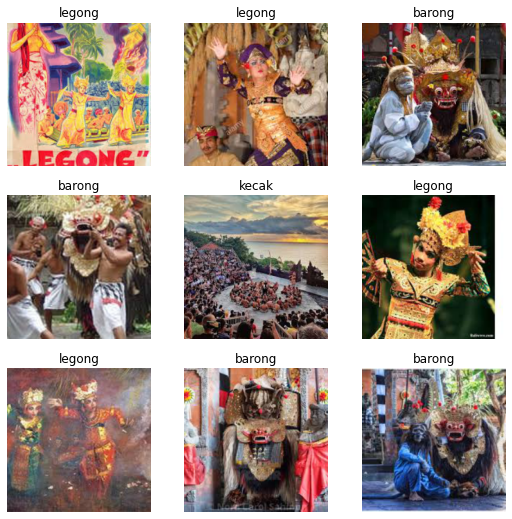

In [ ]:
data.show_batch()

## 3. Build Model and train

- train with ResNet34


In [ ]:
learn = cnn_learner(data, resnet34, metrics=[accuracy, error_rate]) # or metric = error_rate

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.559416,0.689573,0.774510,0.225490,02:25


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.815796,0.439679,0.852941,0.147059,02:30
1,0.632831,0.446613,0.872549,0.127451,02:30
2,0.465921,0.470355,0.892157,0.107843,02:30
3,0.375786,0.451949,0.882353,0.117647,02:30


In [ ]:
learn.save('v2-stage-1')

Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/models/v2-stage-1.pth')

In [ ]:
learn.load('v2-stage-1')

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=9.12010818865383e-07)

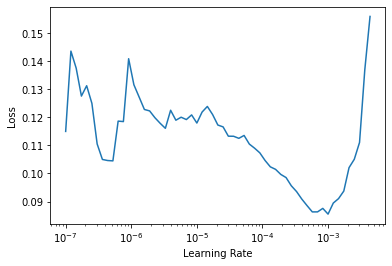

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(3, max_lr=slice() )

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.299670,0.608826,0.813725,0.186275,01:46


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.348356,0.618071,0.803922,0.196078,02:28
1,0.306906,0.621216,0.803922,0.196078,02:29
2,0.276458,0.618096,0.803922,0.196078,02:28


In [ ]:
learn.save('v2-stage-2')   

Path('drive/My Drive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/models/v2-stage-2.pth')

4. Evaluation and Cleaning Up
## Interpretation

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

AttributeError: ignored

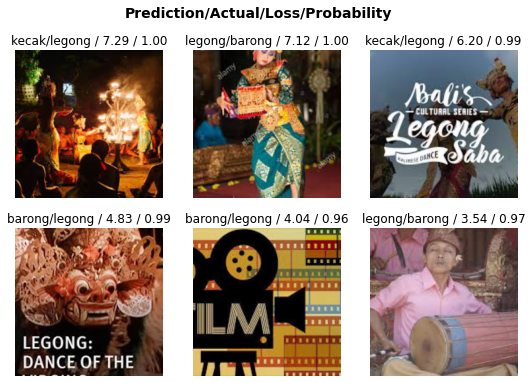

In [ ]:
interp.plot_top_losses(6)

## Cleaning Up 


In [ ]:
# some top losses due to 'bad' imagenet_stats
# use ImageCleaner from fastai.widgets to clean data

from fastai.widgets import *

# file paths with .from_toplosses

In [ ]:
## RUN ONLY FOR 1.st TIME
#########################

# db = (ImageList.from_folder(path).split_none().label_from_folder().transform(get_transforms(), size=224).databunch())

In [ ]:
## check cleaned.csv file

# df = pd.read_csv(path/'cleaned.csv', header='infer')
# df

In [ ]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_df(df, path)
#                    .split_none()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

In [ ]:
# new learner
# learn_clean = cnn_learner(db, models.resnet34, metrics=[accuracy])
# learn_clean.load('stage-2')

In [ ]:
### RUN ONLY ONE TIME !!!
#########################

# get datasets and indexes from toplosses
# ds, idxs = DatasetFormatter().from_toplosses(learn_clean)
# ImageCleaner(ds, idxs, path)

In [ ]:
##### RUN ONLY ONCE 
######################### 
# # find and delete duplicates with .from_similiars()
# ds, idxs = DatasetFormatter.from_similars(learn_clean)
# ImageCleaner(ds, idxs, path, duplicates=True)


'No images to show :)'

In [ ]:
## recreate Databunch from 'cleaned.csv' to train learner on new, cleaned images

## loop over from top

## 5. Production



In [ ]:
## export learner
# learn.export('v2-resnet34')

In [ ]:
## if no gpu available
# defaults.device = torch.device('cpu')

In [ ]:
!pwd
# /content/drive/MyDrive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/v2-resnet34

/content


In [ ]:
learn = load_learner('drive/MyDrive/Colab Notebooks/fast.ai course/lesson2/BaliDance2/v2-resnet34')

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=792x471 at 0x7FAB4E5ED160>


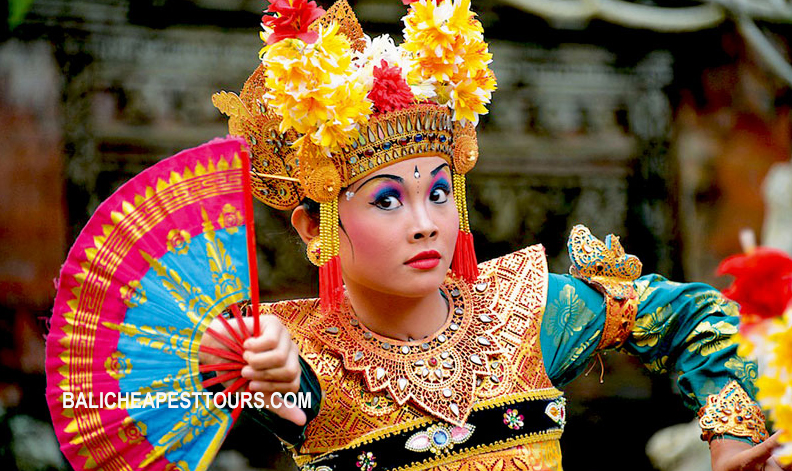

In [ ]:
## open img from url and open as PIL Imag
###########################################

## Option 1:

###################
# url = "https://cdn.pixabay.com/photo/2015/02/24/23/25/barong-648093__340.jpg"
url = 'https://balicheapesttours.com/dummy/bali-legong-dance.jpg'
response = requests.get(url)
# print(response.content)

im = PIL.Image.open(requests.get(url, stream=True).raw)
print(im)
im

In [ ]:
## Transform PIL Image to fastai tensor (w. resize) then to fastai Image Object suitable for model
#######################################################

min_img_size = 224
transform_pipeline = T.Compose([T.Resize(min_img_size), T.ToTensor()])

img = transform_pipeline(im)
# PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
# Currently however, we have (num color channels, height, width); let's fix this by inserting a new axis.
img_unsqueeze = img.unsqueeze(-1)  # Insert the new axis at index 0 i.e. in front of the other axes/dims. 


In [ ]:
## Image from folder
#######################

## fastai v2:
img_pil = PIL.Image.open(path/'legong'/'00000004.jpg')
img_tensor = T.ToTensor()(img_pil)
img_fastai = Image(img_tensor)

In [ ]:
# ## load learner in production from export.pkl with

# learn = load_learner(path) ### path needs to contain export file/ loads empty learner
# ## load weights 
# learn.load('v2-stage-2')


In [ ]:
pred_class, pred_idx, outputs = learn.predict(img_unsqueeze)
pred_class

TypeError: ignored

In [ ]:
learn??

## 6. Conclusion